#Projet Ensemble Learning 2022/2023

**Teacher** : Ah-Pine Julien

**Authors** : Attali Hugo & Djaaleb Tom

In [ ]:
#Si nécessaire
!pip install sklearn
!pip install umap-learn
!pip install imblearn

## Partie 1 : Apprentissage supervisé

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

### Preprocessing

In [3]:
Data = pd.read_csv('https://raw.githubusercontent.com/Tdjaaleb/MALIA/main/Ensemble%20Learning/Data.csv', sep=";")
Data = Data.drop(0)
Data = Data.drop("Unnamed: 0", axis=1)

#Random State
rs=14

Y = Data["Y"]
X = Data.drop("Y", axis=1)

X_quant = X.drop(["X2","X3","X4","X6","X7","X8","X9","X10","X11"], axis=1)

X = preprocessing.normalize(X)
X_quant = preprocessing.normalize(X_quant)

print(Y.value_counts())

0    23364
1     6636
Name: Y, dtype: int64


### 1.1 Logistic Regression, KNN & DT

#### 1.1.1 Logistic Regression

Sans pénalité

In [4]:
LogReg = LogisticRegression(random_state=rs, penalty='none', max_iter=10000, solver='saga')

CvLogReg = cross_val_score(LogReg, X, Y, scoring='accuracy', cv=5, n_jobs=-1)

Accuracy = CvLogReg.sum()/5

print("Accuracy : ", Accuracy)

Accuracy :  0.7787


Avec pénalisation $l_1$, $l_2$ et elasticnet

In [5]:
ratio = [0, 0.1, 0.5, 0.9, 1]
C = [0.01, 0.1]
params = {'l1_ratio' : ratio, "C" : C}
#0 = l2, 1 = l1 
LogReg = LogisticRegression(random_state=rs, penalty='elasticnet', max_iter=10000, solver="saga", n_jobs=-1)

GSCV = GridSearchCV(LogReg, param_grid=params,scoring='accuracy', cv=5, n_jobs=-1)
GSCV.fit(X,Y)

GSCV_results = pd.DataFrame({"l1 ratio" : GSCV.cv_results_['param_l1_ratio'],
                             "C" : GSCV.cv_results_['param_C'],
                             "mean_test_score" : GSCV.cv_results_["mean_test_score"]})
print(GSCV_results)

  l1 ratio     C  mean_test_score
0        0  0.01           0.7788
1      0.1  0.01           0.7788
2      0.5  0.01           0.7788
3      0.9  0.01           0.7788
4        1  0.01           0.7788
5        0   0.1           0.7788
6      0.1   0.1           0.7788
7      0.5   0.1           0.7788
8      0.9   0.1           0.7788
9        1   0.1           0.7788


#### 1.1.2 KNN

In [6]:
n = [3,5,10,15,20]
w = ['uniform', 'distance']
params = {"n_neighbors" : n, 'weights' : w}

KNN = KNeighborsClassifier(n_jobs=-1)

GSCV = GridSearchCV(KNN, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
GSCV.fit(X_quant,Y)

GSCV_results = pd.DataFrame({"n" : GSCV.cv_results_['param_n_neighbors'],
                             "w" : GSCV.cv_results_['param_weights'],
                             "mean_test_score" : GSCV.cv_results_["mean_test_score"]})
print(GSCV_results)
#n = 10 / w = uniform

    n         w  mean_test_score
0   3   uniform         0.744667
1   3  distance         0.742333
2   5   uniform         0.765667
3   5  distance         0.763133
4  10   uniform         0.781533
5  10  distance         0.774933
6  15   uniform         0.779167
7  15  distance         0.779233
8  20   uniform         0.781500
9  20  distance         0.781033


#### 1.1.3 Decision Tree

In [7]:
min_split = [2, 10, 100, 500, 1000]

params = {'min_samples_split' : min_split}

DT = DecisionTreeClassifier(criterion='entropy', random_state=rs)

GSCV = GridSearchCV(DT, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
GSCV.fit(X,Y)

GSCV_results = pd.DataFrame({"min_split" : GSCV.cv_results_['param_min_samples_split'],
                             "mean_test_score" : GSCV.cv_results_["mean_test_score"]})
print(GSCV_results)

  min_split  mean_test_score
0         2         0.732200
1        10         0.733033
2       100         0.791867
3       500         0.808133
4      1000         0.812100


### 1.2 Aggregation

Système de vote à majorité avec estimateurs non biaisés

In [8]:
LogReg = LogisticRegression(random_state=rs, penalty="none", max_iter=10000,solver='saga')
KNN = KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='uniform')
DT = DecisionTreeClassifier(criterion='entropy', random_state=rs, min_samples_split=2)

Voting = VotingClassifier(estimators=[('LogReg', LogReg),('KNN', KNN),('DT', DT)], n_jobs=-1, voting='hard')

CvVoting = cross_val_score(Voting, X, Y, cv=5, scoring='accuracy', n_jobs=-1)

Accuracy = CvVoting.sum()/5

print("Accuracy : ", Accuracy)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Accuracy :  0.7838333333333334


Système de vote pondéré avec estimateurs non biaisés

In [9]:
Voting = VotingClassifier(estimators=[('LogReg', LogReg),('KNN', KNN),('DT', DT)], n_jobs=-1, voting='soft')

CvVoting = cross_val_score(Voting, X, Y, cv=5, scoring='accuracy', n_jobs=-1)

Accuracy = CvVoting.sum()/5

print("Accuracy : ", Accuracy)

Accuracy :  0.7730333333333334


Système de vote majoritaire avec estimateurs biaisés

In [10]:
LogReg = LogisticRegression(random_state=rs, penalty="none", max_iter=10000,solver='saga')
KNN = KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='uniform')
DT = DecisionTreeClassifier(criterion='entropy', random_state=rs, min_samples_split=1000)

Voting = VotingClassifier(estimators=[('LogReg', LogReg),('KNN', KNN),('DT', DT)], n_jobs=-1, voting='hard')

CvVoting = cross_val_score(Voting, X, Y, cv=5, scoring='accuracy', n_jobs=-1)

Accuracy = CvVoting.sum()/5

print("Accuracy : ", Accuracy)

Accuracy :  0.7882333333333333


### 1.3 Stacking

Stacking avec linear-SVM

In [11]:
LogReg = LogisticRegression(random_state=rs, penalty="none", max_iter=10000,solver='saga')
KNN = KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='uniform')
DT = DecisionTreeClassifier(criterion='entropy', random_state=rs, min_samples_split=2)

Svc = SVC(kernel='linear', random_state=rs)

Stacking = StackingClassifier(estimators=[('LogReg', LogReg),('KNN', KNN),('DT', DT)], final_estimator=Svc, n_jobs=-1)

CvStacking = cross_val_score(Stacking, X, Y, cv=5, scoring='accuracy', n_jobs=-1)

Accuracy = CvStacking.sum()/5

print("Accuracy : ", Accuracy)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Accuracy :  0.7788000000000002


Stacking avec poly-SVM


In [12]:
Svc = SVC(kernel='poly', random_state=rs)

Stacking = StackingClassifier(estimators=[('LogReg', LogReg),('KNN', KNN),('DT', DT)], final_estimator=Svc, n_jobs=-1)

CvStacking = cross_val_score(Stacking, X, Y, cv=5, scoring='accuracy', n_jobs=-1)

Accuracy = CvStacking.sum()/5

print("Accuracy : ", Accuracy)

Accuracy :  0.7840333333333334


Stacking avec rbf-SVM

In [13]:
Svc = SVC(kernel='rbf', random_state=rs)

Stacking = StackingClassifier(estimators=[('LogReg', LogReg),('KNN', KNN),('DT', DT)], final_estimator=Svc, n_jobs=-1)

CvStacking = cross_val_score(Stacking, X, Y, cv=5, scoring='accuracy', n_jobs=-1)

Accuracy = CvStacking.sum()/5

print("Accuracy : ", Accuracy)

Accuracy :  0.7852333333333332


### 1.4 Random Forest

Optimisation des hyperparamètres en utilisant l'erreur OOB

In [14]:
r = [1, 5, 8, 15, 23]
t = [10, 100, 200, 500, 1000]
min_split = [2, 10, 100, 500, 1000]

RFC = RandomForestClassifier(criterion='entropy', bootstrap=True, oob_score=True, random_state=rs, n_jobs=-1)

grid_r=[]
grid_t=[]
grid_min=[]
grid_oob=[]
for i,x in enumerate(r):
  for j,y in enumerate(t):
    for k,z in enumerate(min_split):
      RFC.set_params(max_features=x,
                     min_samples_split=z,
                     n_estimators=y,
                     max_samples=y)
      
      RFC.fit(X, Y)
      oob = RFC.oob_score_

      grid_r.append(x)
      grid_t.append(y)
      grid_min.append(z)
      grid_oob.append(oob)

GS_results = pd.DataFrame(
    {"r" : grid_r,
     "t" : grid_t,
     "min_split" : grid_min,
     "oob_score" : grid_oob}
)

print(GS_results.sort_values("oob_score", ascending=False).head(10))
#r=23, t=1000, min_split=2

      r     t  min_split  oob_score
120  23  1000          2   0.818833
121  23  1000         10   0.818400
95   15  1000          2   0.817567
90   15   500          2   0.817233
96   15  1000         10   0.816833
116  23   500         10   0.816733
115  23   500          2   0.816300
71    8  1000         10   0.816233
65    8   500          2   0.816033
70    8  1000          2   0.816033


Évolution de l'accuracy OOB en fonction des hyperparamètres

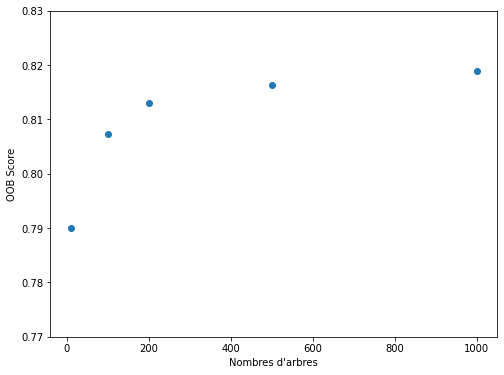

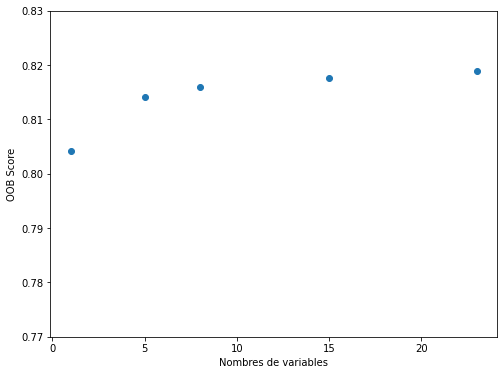

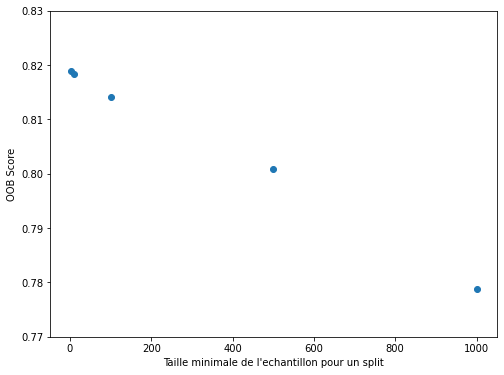

In [15]:
t_score=GS_results.where(GS_results["r"]==23).dropna().where(GS_results["min_split"]==2).dropna()
r_score=GS_results.where(GS_results["t"]==1000).dropna().where(GS_results["min_split"]==2).dropna()
min_score=GS_results.where(GS_results["t"]==1000).dropna().where(GS_results["r"]==23).dropna()


#Évolution de l'accuracy OOB en fonction du nombre d'arbres
plt.figure(figsize=(8,6))
plt.ylim((0.77,0.83))
plt.xlabel("Nombres d'arbres")
plt.ylabel("OOB Score")
plt.scatter(t_score["t"], t_score['oob_score'])

#plt.savefig("RF_oob1.jpg")
#files.download("RF_oob1.jpg")

#Évolution de l'accuracy OOB en fonction du nombre de variables choisies pour évaluer un split
plt.figure(figsize=(8,6))
plt.ylim((0.77,0.83))
plt.xlabel("Nombres de variables")
plt.ylabel("OOB Score")
plt.scatter(r_score["r"], r_score['oob_score'])

#plt.savefig("RF_oob2.jpg")
#files.download("RF_oob2.jpg")

#Évolution de l'accuracy OOB en fonction de la taille minimale de l'échantillon requise pour un split
plt.figure(figsize=(8,6))
plt.ylim((0.77,0.83))
plt.xlabel("Taille minimale de l'echantillon pour un split")
plt.ylabel("OOB Score")
plt.scatter(min_score["min_split"], min_score['oob_score'])

#plt.savefig("RF_oob3.jpg")
#files.download("RF_oob3.jpg")

Mesure de la performance des Random Forests sur notre jeu de données à l'aide de la validation croisée

In [16]:
RFC = RandomForestClassifier(
   criterion='entropy',
   bootstrap=True,
   random_state=rs, 
   n_jobs=-1,
   max_features=23,
   n_estimators=1000,
   max_samples=1000,
   min_samples_split=2
)

CvRFC = cross_val_score(RFC, X, Y, cv=5, scoring='accuracy', n_jobs=-1)

Accuracy = CvRFC.sum()/5

print("Accuracy : ", Accuracy)

Accuracy :  0.8177666666666668


### 1.5 AdaBoost

GridSearchCV(learning rate, profondeur max)

In [17]:
#3 Different weak classifiers based on max depth of the trees
DT1 = DecisionTreeClassifier(criterion='entropy', random_state=rs, max_depth=1)
DT5 = DecisionTreeClassifier(criterion='entropy', random_state=rs, max_depth=5)
DT10 = DecisionTreeClassifier(criterion='entropy', random_state=rs, max_depth=10)

#Accuracy of weak classifiers
CvDT1 = cross_val_score(DT1, X, Y, cv=5, scoring='accuracy', n_jobs=-1)
AccuracyDT1 = CvDT1.sum()/5
print("Accuracy_DT1 : ", AccuracyDT1)

CvDT5 = cross_val_score(DT5, X, Y, cv=5, scoring='accuracy', n_jobs=-1)
AccuracyDT5 = CvDT5.sum()/5
print("Accuracy_DT5 : ", AccuracyDT5)

CvDT10 = cross_val_score(DT10, X, Y, cv=5, scoring='accuracy', n_jobs=-1)
AccuracyDT10 = CvDT10.sum()/5
print("Accuracy_DT10 : ", AccuracyDT10)

#Parameters tested in the GridSearchCV method
lr = [0.1,1,10]
estimator = [DT1, DT5, DT10]
params={"learning_rate" : lr, "base_estimator" : estimator}

Ada = AdaBoostClassifier(random_state=rs, algorithm='SAMME', n_estimators=50)

GSCV = GridSearchCV(Ada, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
GSCV.fit(X,Y)

#Output
GSCV_results = pd.DataFrame({"estimator_depth" : [1,1,1,5,5,5,10,10,10],
                             "learning_rate" : GSCV.cv_results_['param_learning_rate'],
                             "mean_test_score" : GSCV.cv_results_["mean_test_score"]})
print(GSCV_results.sort_values("mean_test_score", ascending=False))

Accuracy_DT1 :  0.7745666666666667
Accuracy_DT5 :  0.8117000000000001
Accuracy_DT10 :  0.8015666666666668
   estimator_depth learning_rate  mean_test_score
3                5           0.1         0.815100
6               10           0.1         0.814700
4                5             1         0.809433
1                1             1         0.805667
0                1           0.1         0.803467
7               10             1         0.789333
2                1            10         0.774567
5                5            10         0.659500
8               10            10         0.548200


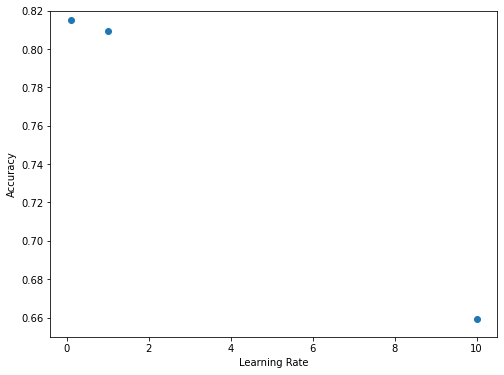

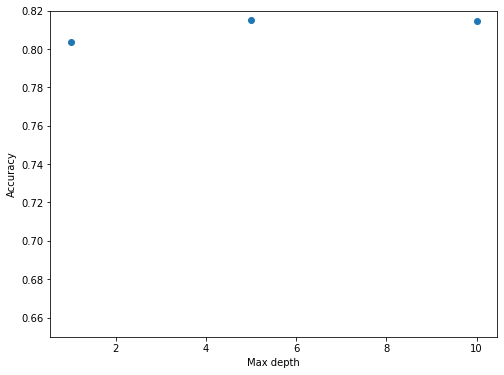

In [18]:
lr_score=GSCV_results.where(GSCV_results["estimator_depth"]==5).dropna()
d_score=GSCV_results.where(GSCV_results["learning_rate"]==0.1).dropna()

#Évolution de l'accuracy en fonction du learning rate
plt.figure(figsize=(8,6))
plt.ylim((0.65,0.82))
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.scatter(lr_score["learning_rate"], lr_score['mean_test_score'])

#plt.savefig("ADA1.jpg")
#files.download("ADA1.jpg")

#Évolution de l'accuracy en fonction de la profondeur de l'arbre
plt.figure(figsize=(8,6))
plt.ylim((0.65,0.82))
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.scatter(d_score["estimator_depth"], d_score['mean_test_score'])

#plt.savefig("ADA2.jpg")
#files.download("ADA2.jpg")

GridSearchCV(n estimator) avec profondeur des arbres = 5

In [19]:
DT = DecisionTreeClassifier(criterion='entropy', random_state=rs, max_depth=5)

CvDT = cross_val_score(DT, X, Y, cv=5, scoring='accuracy', n_jobs=-1)

Accuracy = CvDT.sum()/5

print("Accuracy_DT : ", Accuracy)

n_estimators=[5, 10, 20, 100, 500, 1000]
params={"n_estimators" : n_estimators}

Ada = AdaBoostClassifier(base_estimator = DT, random_state=rs, algorithm='SAMME', learning_rate=0.01)

GSCV = GridSearchCV(Ada, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
GSCV.fit(X,Y)

GSCV_results = pd.DataFrame({"n_estimators" : GSCV.cv_results_['param_n_estimators'],
                             "mean_test_score" : GSCV.cv_results_["mean_test_score"]})
print(GSCV_results)

Accuracy_DT :  0.8117000000000001
  n_estimators  mean_test_score
0            5         0.813733
1           10         0.815133
2           20         0.815033
3          100         0.816233
4          500         0.815333
5         1000         0.814733


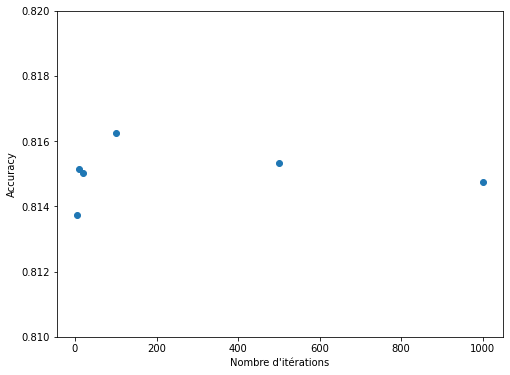

In [20]:
plt.figure(figsize=(8,6))
plt.ylim((0.81,0.82))
plt.xlabel("Nombre d'itérations")
plt.ylabel("Accuracy")
plt.scatter(GSCV_results["n_estimators"], GSCV_results['mean_test_score'])

#plt.savefig("ADA3.jpg")
#files.download("ADA3.jpg")

### 1.6 Gradient Boosting

In [21]:
max_features = [1, 5, 8, 15, 23]
max_depth = [1, 5, 10]
n = [100, 500, 1000]

params = {
    "n_estimators" : n,
    "max_depth" : max_depth,
    "max_features" : max_features
}

GB = GradientBoostingClassifier(random_state=rs, loss='deviance', criterion='squared_error')

GSCV = GridSearchCV(GB, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
GSCV.fit(X,Y)

GSCV_results = pd.DataFrame({"n_estimators" : GSCV.cv_results_['param_n_estimators'],
                             "max_depth" : GSCV.cv_results_['param_max_depth'],
                             "max_features" : GSCV.cv_results_['param_max_features'],
                             "mean_test_score" : GSCV.cv_results_["mean_test_score"]})

print(GSCV_results.sort_values("mean_test_score", ascending=False).head(10))
#max_f = 5 / max_d = 5 / n = 100

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   n_estimators max_depth max_features  mean_test_score
18          100         5            5         0.814333
24          100         5           15         0.814033
21          100         5            8         0.813700
27          100         5           23         0.813333
36          100        10            8         0.812233
37          500        10            8         0.812100
25          500         5           15         0.811567
19          500         5            5         0.811300
26         1000         5           15         0.810533
22          500         5            8         0.810400


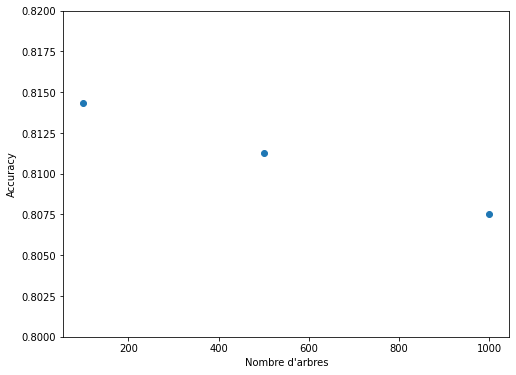

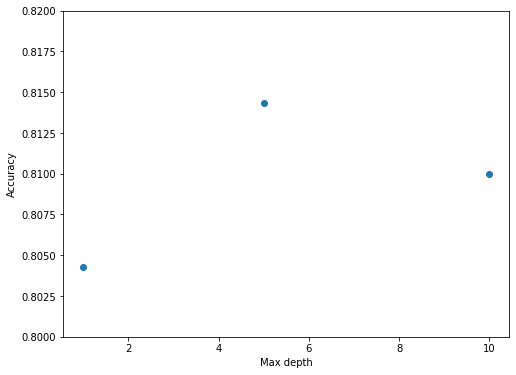

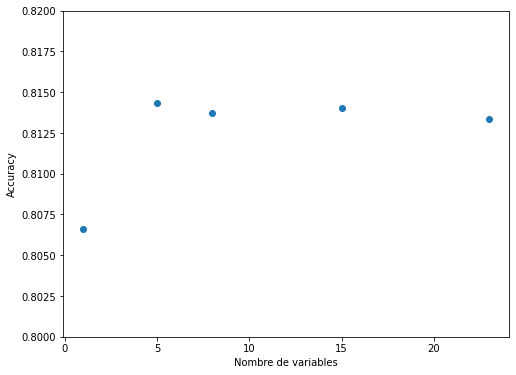

In [22]:
n_score = GSCV_results.where(GSCV_results["max_depth"]==5).dropna().where(GSCV_results["max_features"]==5).dropna()
d_score = GSCV_results.where(GSCV_results["n_estimators"]==100).dropna().where(GSCV_results["max_features"]==5).dropna()
f_score = GSCV_results.where(GSCV_results["n_estimators"]==100).dropna().where(GSCV_results["max_depth"]==5).dropna()

#Évolution de l'accuracy en fonction du nombre d'arbres
plt.figure(figsize=(8,6))
plt.ylim((0.8,0.82))
plt.xlabel("Nombre d'arbres")
plt.ylabel("Accuracy")
plt.scatter(n_score["n_estimators"], n_score['mean_test_score'])

#plt.savefig("GB1.jpg")
#files.download("GB1.jpg")

#Évolution de l'accuracy en fonction de la profondeur de l'arbre
plt.figure(figsize=(8,6))
plt.ylim((0.8,0.82))
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.scatter(d_score["max_depth"], d_score['mean_test_score'])

#plt.savefig("GB2.jpg")
#files.download("GB2.jpg")

#Évolution de l'accuracy en fonction du nombre de variables
plt.figure(figsize=(8,6))
plt.ylim((0.8,0.82))
plt.xlabel("Nombre de variables")
plt.ylabel("Accuracy")
plt.scatter(f_score["max_features"], f_score['mean_test_score'])

#plt.savefig("GB3.jpg")
#files.download("GB3.jpg")

### 1.7 Comparaison des méthodes

#### En terme de performance en classification

In [23]:
Name = ["LogReg","KNN","DT","Voting","Stacking","RFC","Ada","GB"]
Accuracy = []
Precision = []
Recall = []

metrics = {
    "accuracy": "accuracy",
    "precision" : make_scorer(precision_score,average="binary", pos_label="1"),
    "recall" : make_scorer(recall_score,average='binary', pos_label="1")
}

Par soucis de mémoire, nous devons effectuer les tests un par un

In [24]:
#Model 1
LogReg = LogisticRegression(random_state=rs, penalty='none', max_iter=10000, solver='saga')
LogRegCV = cross_validate(LogReg, X, Y, scoring=metrics, cv=5, n_jobs=-1)

Accuracy.append(LogRegCV["test_accuracy"].sum()/5)
Precision.append(LogRegCV["test_precision"].sum()/5)
Recall.append(LogRegCV["test_recall"].sum()/5)

In [25]:
#Model 2
KNN = KNeighborsClassifier(n_neighbors = 10, weights='uniform', n_jobs=-1)
KNNCV = cross_validate(KNN, X_quant, Y, scoring=metrics, cv=5, n_jobs=-1)

Accuracy.append(KNNCV["test_accuracy"].sum()/5)
Precision.append(KNNCV["test_precision"].sum()/5)
Recall.append(KNNCV["test_recall"].sum()/5)

In [26]:
#Model 3
DT = DecisionTreeClassifier(min_samples_split=1000, criterion='entropy', random_state=rs)
DTCV = cross_validate(DT, X, Y, scoring=metrics, cv=5, n_jobs=-1)

Accuracy.append(DTCV["test_accuracy"].sum()/5)
Precision.append(DTCV["test_precision"].sum()/5)
Recall.append(DTCV["test_recall"].sum()/5)

In [27]:
#Model 4
Voting = VotingClassifier(estimators=[('LogReg', LogReg),('KNN', KNN),('DT', DT)], n_jobs=-1, voting='hard')
VotingCV = cross_validate(Voting, X, Y, scoring=metrics, cv=5, n_jobs=-1)

Accuracy.append(VotingCV["test_accuracy"].sum()/5)
Precision.append(VotingCV["test_precision"].sum()/5)
Recall.append(VotingCV["test_recall"].sum()/5)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [28]:
#Model 5
KNN_stacking = KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='uniform')
DT_stacking = DecisionTreeClassifier(criterion='entropy', random_state=rs, min_samples_split=2)
Svc = SVC(kernel='rbf', random_state=rs)

Stacking = StackingClassifier(estimators=[('LogReg', LogReg),('KNN', KNN_stacking),('DT', DT_stacking)], final_estimator=Svc, n_jobs=-1)
StackingCV = cross_validate(Stacking, X, Y, scoring=metrics, cv=5, n_jobs=-1)

Accuracy.append(StackingCV["test_accuracy"].sum()/5)
Precision.append(StackingCV["test_precision"].sum()/5)
Recall.append(StackingCV["test_recall"].sum()/5)

In [29]:
#Model 6
RFC = RandomForestClassifier(criterion='entropy', bootstrap=True, random_state=rs, n_jobs=-1, max_features=23, n_estimators=1000, max_samples=1000, min_samples_split=2)
RFCCV = cross_validate(RFC, X, Y, scoring=metrics, cv=5, n_jobs=-1)

Accuracy.append(RFCCV["test_accuracy"].sum()/5)
Precision.append(RFCCV["test_precision"].sum()/5)
Recall.append(RFCCV["test_recall"].sum()/5)

In [30]:
#Model 7
DT5 = DecisionTreeClassifier(criterion='entropy', random_state=rs, max_depth=5)

Ada = AdaBoostClassifier(random_state=rs, algorithm='SAMME', n_estimators=50, learning_rate=0.1, base_estimator=DT5)
AdaCV = cross_validate(Ada, X, Y, scoring=metrics, cv=5, n_jobs=-1)

Accuracy.append(AdaCV["test_accuracy"].sum()/5)
Precision.append(AdaCV["test_precision"].sum()/5)
Recall.append(AdaCV["test_recall"].sum()/5)

In [31]:
#Model 8
GB = GradientBoostingClassifier(random_state=rs, loss='deviance', criterion='squared_error', max_features=5, max_depth=5, n_estimators=100)
GBCV = cross_validate(GB, X, Y, scoring=metrics, cv=5, n_jobs=-1)

Accuracy.append(GBCV["test_accuracy"].sum()/5)
Precision.append(GBCV["test_precision"].sum()/5)
Recall.append(GBCV["test_recall"].sum()/5)

In [32]:
Results = pd.DataFrame({
    "Modele" : Name,
    "Accuracy" : Accuracy,
    "Precision" : Precision,
    "Recall" : Recall
})

In [33]:
print(Results)

     Modele  Accuracy  Precision    Recall
0    LogReg  0.778700   0.499952  0.024263
1       KNN  0.781533   0.535307  0.103377
2        DT  0.812100   0.638941  0.350967
3    Voting  0.788233   0.709844  0.073690
4  Stacking  0.785233   0.620656  0.074595
5       RFC  0.817767   0.653730  0.377944
6       Ada  0.815100   0.651017  0.358353
7        GB  0.814333   0.641041  0.367846


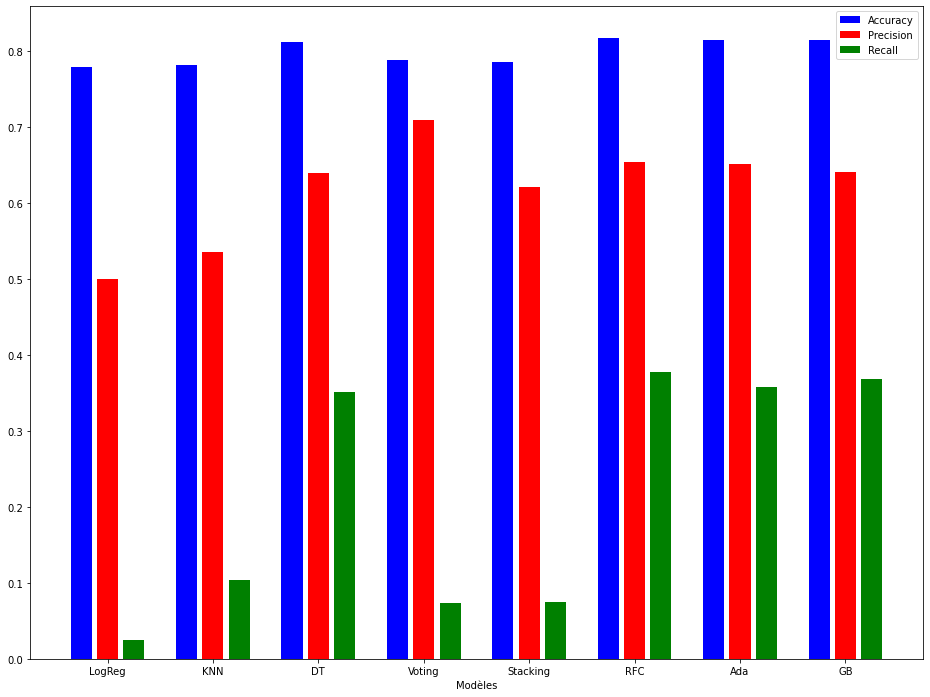

In [34]:
plt.figure(figsize=(16,12))
x = np.array([1,3,5,7,9,11,13,15])
plt.bar(x,Results["Accuracy"],width=0.4, color="blue", label="Accuracy")
plt.bar(x+0.5,Results["Precision"], width=0.4, color="red", label="Precision")
plt.bar(x+1,Results["Recall"], width=0.4, color="green", label="Recall")
plt.xlabel("Modèles")
plt.xticks(x+0.5, Results["Modele"])
plt.legend()

#plt.savefig("Resultats.jpg")
#files.download("Resultats.jpg")

#### En terme de vitesse d'entraînement

In [35]:
#Model 1
start = time.time()
LogReg.fit(X,Y)
end = time.time()
print("Logistic Regression : ", end-start)

#Model 2
start = time.time()
KNN.fit(X_quant,Y)
end = time.time()
print("KNN : ", end-start)

#Model 3
start = time.time()
DT.fit(X,Y)
end = time.time()
print("Decision Tree : ", end-start)

#Model 4
start = time.time()
Voting.fit(X,Y)
end = time.time()
print("Voting : ", end-start)

#Model 5
start = time.time()
Stacking.fit(X,Y)
end = time.time()
print("Stacking : ", end-start)

#Model 6
start = time.time()
RFC.fit(X,Y)
end = time.time()
print("Random Forest : ", end-start)

#Model 7
start = time.time()
Ada.fit(X,Y)
end = time.time()
print("AdaBoost : ", end-start)

#Model 8
start = time.time()
GB.fit(X,Y)
end = time.time()
print("Gradient Boosting : ", end-start)

Logistic Regression :  47.306981325149536
KNN :  0.10386395454406738
Decision Tree :  1.113645315170288
Voting :  45.17294931411743
Stacking :  196.67998218536377
Random Forest :  14.519897937774658
AdaBoost :  28.705506086349487
Gradient Boosting :  8.375750303268433


## Partie 2 : Apprentissage non-supervisé

In [36]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, SpectralClustering
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.decomposition import PCA

import umap.umap_ as umap

from imblearn.over_sampling import KMeansSMOTE, SVMSMOTE, RandomOverSampler, SMOTE, BorderlineSMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

#MARCHE PAS
#from sklearn.cluster import BisectingKMeans

### 2.1 Réduction de dimension des méthodes pour visualisation

Réduction de dimensions pour visualiser le clustering soit umap soit acp

In [37]:
def reduc_dim(methode='umap',X=X):
    if methode=='umap':
        print("umap")
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(X)
    elif methode=='acp' :
        print("acp")
        # Modèle d'ACP
        mypca = PCA(n_components=2)
        mypca.fit(X)
        # Pourcentage de la variance expliquée par chacune des composantes sélectionnées.
        #print(mypca.singular_values_) # Valeurs de variance
        #print(mypca.explained_variance_ratio_) #  Pourcentages
        # Axes principaux dans l'espace des caractéristiques, représentant les directions de la variance maximale dans les données. Les composantes sont triées par variance expliquée.
        #print(mypca.components_) # 
        # Résultats de l'ACP
        embedding = mypca.fit_transform(X)
    return embedding

#### UMAP

umap


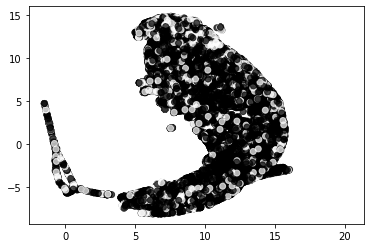

In [38]:
embedding_umap = reduc_dim(methode='umap')
plt.scatter(embedding_umap[:,0],embedding_umap[:,1],c=Y.to_numpy(),alpha = 0.7)

#### ACP

acp


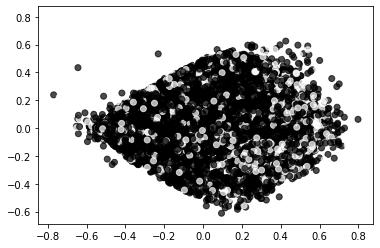

In [39]:
embedding_acp = reduc_dim(methode='acp')
plt.scatter(embedding_acp[:,0],embedding_acp[:,1],c=Y.to_numpy(),alpha = 0.7)

Nombre de clusters optimal

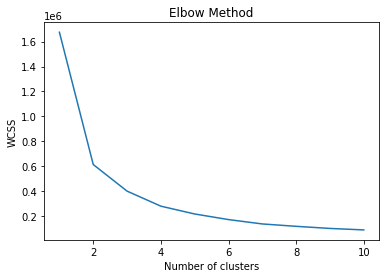

In [40]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=10, n_init=10, random_state=0)
    kmeans.fit(embedding_umap)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### 2.2 KMeans

In [41]:
def kmeans(array = X, init = 'k-means++',n_clusters=2,methode_reducdim ='umap',visu=0,true_pred=Y):
    if methode_reducdim =='umap':
        embedding_ = embedding_umap
    else :
        embedding_ = embedding_acp
    kmeans = KMeans(n_clusters=n_clusters, init=init, max_iter=300, n_init=10, random_state=rs)
    pred_y = kmeans.fit_predict(array)
    if visu == 1 :
        newX = kmeans.fit_transform(embedding_)
        plt.scatter(embedding_[:,0],embedding_[:,1],c=true_pred.astype('int').to_numpy())
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red')
        plt.title('Représentation des centroides des clusters en fonction des données réeles')
        plt.show()
        print("la mesure Normalized Mutual Information est ",normalized_mutual_info_score(Y.to_numpy(),pred_y))
        ConfusionMatrixDisplay.from_predictions(true_pred.astype('int').to_numpy(),pred_y)
        plt.show()
        print(classification_report(true_pred.astype('int').to_numpy(), pred_y, labels=[0,1]))
    return pred_y

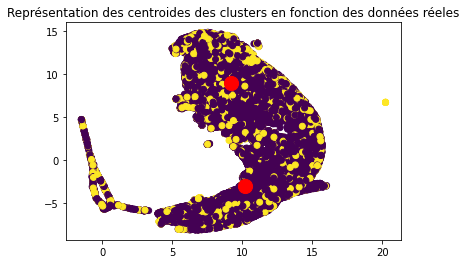

la mesure Normalized Mutual Information est  0.00748340300438248


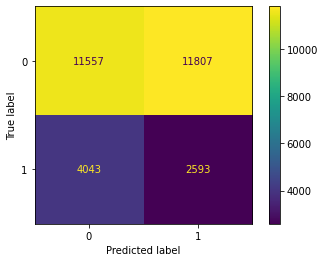

              precision    recall  f1-score   support

           0       0.74      0.49      0.59     23364
           1       0.18      0.39      0.25      6636

    accuracy                           0.47     30000
   macro avg       0.46      0.44      0.42     30000
weighted avg       0.62      0.47      0.52     30000



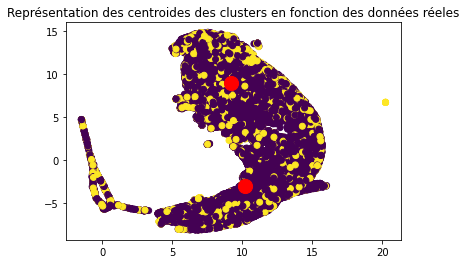

la mesure Normalized Mutual Information est  0.0074800733176207885


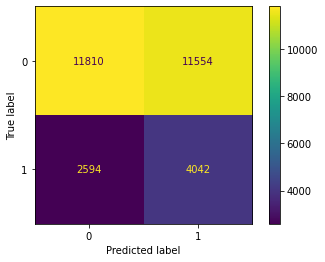

              precision    recall  f1-score   support

           0       0.82      0.51      0.63     23364
           1       0.26      0.61      0.36      6636

    accuracy                           0.53     30000
   macro avg       0.54      0.56      0.49     30000
weighted avg       0.70      0.53      0.57     30000



array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [42]:
kmeans(init='random',n_clusters=2,visu=1) #init  aléatoire (Kmeans très sensible à l'initialisation)
kmeans(init = 'k-means++',n_clusters=2,visu=1)
kmeans(init = 'k-means++',n_clusters=2,methode_reducdim ='acp')
kmeans(init='random',n_clusters=2,methode_reducdim ='acp')

### 2.3 Classification Hiérarchique Ascendante

In [43]:
def CAH(array = X, linkage='ward',n_clusters = 2,true_pred=Y,affinity='euclidean',visu=0):
# Segmentation à l'aide d'une CAH
    y_pred = AgglomerativeClustering(linkage=linkage, n_clusters = n_clusters,affinity=affinity).fit_predict(array)
    #“l1”, “l2”, “manhattan”, “cosine”
    print(linkage)
    print(affinity)
    # Visualisation du résultat
    true_pred = true_pred.astype('int')
    confusion_matrix(true_pred.to_numpy(),y_pred)
    if visu == 1:
        ConfusionMatrixDisplay.from_predictions(true_pred.to_numpy(), y_pred)
        print("la mesure Normalized Mutual Information est ",normalized_mutual_info_score(Y.to_numpy(),y_pred))
        plt.show()
        print(classification_report(Y.astype('int').to_numpy(), y_pred, labels=[0,1]))
    return y_pred

ward
euclidean
la mesure Normalized Mutual Information est  0.002438333863868487


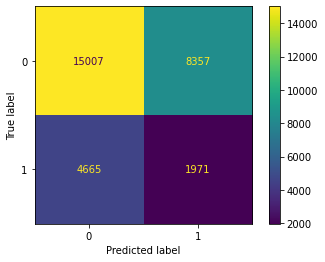

              precision    recall  f1-score   support

           0       0.76      0.64      0.70     23364
           1       0.19      0.30      0.23      6636

    accuracy                           0.57     30000
   macro avg       0.48      0.47      0.46     30000
weighted avg       0.64      0.57      0.59     30000

complete
l1
la mesure Normalized Mutual Information est  0.008018192707025052


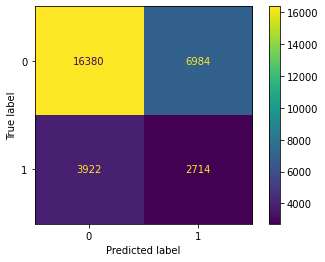

              precision    recall  f1-score   support

           0       0.81      0.70      0.75     23364
           1       0.28      0.41      0.33      6636

    accuracy                           0.64     30000
   macro avg       0.54      0.56      0.54     30000
weighted avg       0.69      0.64      0.66     30000

complete
l2
la mesure Normalized Mutual Information est  0.00013209124777732278


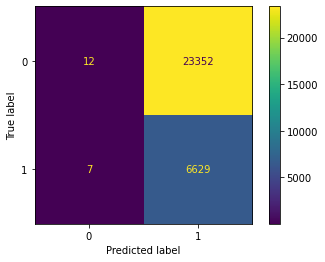

              precision    recall  f1-score   support

           0       0.63      0.00      0.00     23364
           1       0.22      1.00      0.36      6636

    accuracy                           0.22     30000
   macro avg       0.43      0.50      0.18     30000
weighted avg       0.54      0.22      0.08     30000

complete
manhattan
la mesure Normalized Mutual Information est  0.008018192707025052


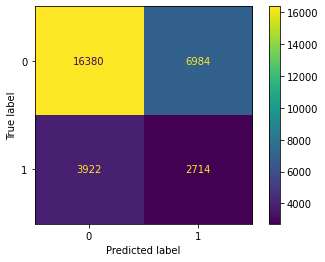

              precision    recall  f1-score   support

           0       0.81      0.70      0.75     23364
           1       0.28      0.41      0.33      6636

    accuracy                           0.64     30000
   macro avg       0.54      0.56      0.54     30000
weighted avg       0.69      0.64      0.66     30000

complete
cosine
la mesure Normalized Mutual Information est  0.00011453473570088145


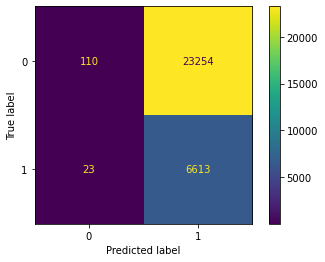

              precision    recall  f1-score   support

           0       0.83      0.00      0.01     23364
           1       0.22      1.00      0.36      6636

    accuracy                           0.22     30000
   macro avg       0.52      0.50      0.19     30000
weighted avg       0.69      0.22      0.09     30000

single
euclidean
la mesure Normalized Mutual Information est  0.00019021028981878744


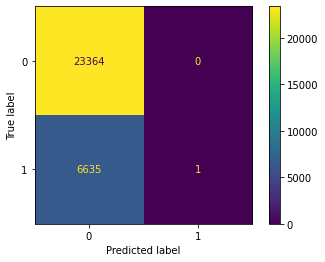

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     23364
           1       1.00      0.00      0.00      6636

    accuracy                           0.78     30000
   macro avg       0.89      0.50      0.44     30000
weighted avg       0.83      0.78      0.68     30000

average
euclidean
la mesure Normalized Mutual Information est  0.00019021028981878744


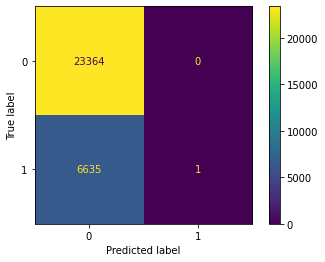

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     23364
           1       1.00      0.00      0.00      6636

    accuracy                           0.78     30000
   macro avg       0.89      0.50      0.44     30000
weighted avg       0.83      0.78      0.68     30000



In [44]:
cah_Ward = CAH(linkage='ward',visu=1)
cah_complete = CAH(linkage='complete',affinity='l1',visu=1)
cah_complete = CAH(linkage='complete',affinity='l2',visu=1)
cah_complete = CAH(linkage='complete',affinity='manhattan',visu=1)
cah_complete = CAH(linkage='complete',affinity='cosine',visu=1)
cah_single = CAH(linkage='single',visu=1)
cah_average = CAH(linkage='average',visu=1)

### 2.4 DBSCAN : Méthode par densité de proba

eps 0.1
min_samples 1
Nombre de cluster: 882
Nombre de point considéré comme du bruit: 0
DBSCAN
la mesure Normalized Mutual Information est  0.019596197019420742
eps 0.1
min_samples 2
Nombre de cluster: 442
Nombre de point considéré comme du bruit: 440
DBSCAN
la mesure Normalized Mutual Information est  0.01463563152376095
eps 0.1
min_samples 3
Nombre de cluster: 298
Nombre de point considéré comme du bruit: 728
DBSCAN
la mesure Normalized Mutual Information est  0.01263204738870122
eps 0.1
min_samples 4
Nombre de cluster: 264
Nombre de point considéré comme du bruit: 1199
DBSCAN
la mesure Normalized Mutual Information est  0.01577278566109711
eps 0.1
min_samples 5
Nombre de cluster: 279
Nombre de point considéré comme du bruit: 1760
DBSCAN
la mesure Normalized Mutual Information est  0.015361549856363689
eps 0.1
min_samples 6
Nombre de cluster: 299
Nombre de point considéré comme du bruit: 2476
DBSCAN
la mesure Normalized Mutual Information est  0.014679948041592523
eps 0.1
min_sample

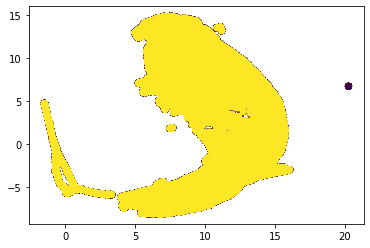

In [45]:
for i in np.arange(0.1, 2, 0.1): #Grid search sur le parametre eps
    for j in np.arange(1, 10, 1): #Grid search sur le parametre min_samples
        print('eps', i)
        print('min_samples', j)
        db = DBSCAN(eps=i, min_samples=j).fit(embedding_umap)
        core_samples_mask = np.zeros_like(Y.to_numpy(), dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        print("Nombre de cluster: %d" % n_clusters_)
        print("Nombre de point considéré comme du bruit: %d" % n_noise_)

        print("DBSCAN")
        plt.scatter(embedding_umap[:,0],embedding_umap[:,1],c=labels)

        print("la mesure Normalized Mutual Information est ",normalized_mutual_info_score(Y.to_numpy(),labels))

### 2.5 Spectral Clustering

In [46]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X,Y, random_state=rs, stratify=Y, test_size=0.5) #On divise nos données car la mémoire est surchargé sinon
embed = reduc_dim(X=X_Train,methode ='umap')

def spec_clust(array=X_Train,n_clusters=2,affinity='rbf',embed=embed,true_pred=Y_Train):
    print(affinity)
    sc = SpectralClustering(n_clusters=n_clusters,affinity=affinity,random_state=rs).fit(array)
    labels = sc.labels_
    plt.scatter(embed[:,0], embed[:,1], c=labels)
    plt.title("Représentation des clusters selon notre méthode")
    plt.show()
    true_pred = true_pred.astype('int')
    confusion_matrix(true_pred.to_numpy(),labels)
    print(classification_report(true_pred.to_numpy(), labels, labels=[0,1]))
    print("la mesure Normalized Mutual Information est ",normalized_mutual_info_score(true_pred.to_numpy(),labels))

umap


rbf


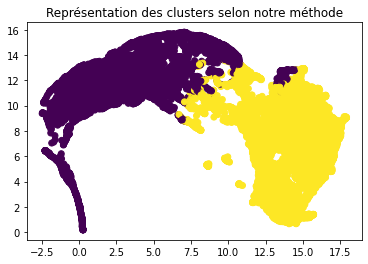

              precision    recall  f1-score   support

           0       0.82      0.51      0.63     11682
           1       0.26      0.60      0.36      3318

    accuracy                           0.53     15000
   macro avg       0.54      0.56      0.50     15000
weighted avg       0.70      0.53      0.57     15000

la mesure Normalized Mutual Information est  0.007343206692699093
polynomial


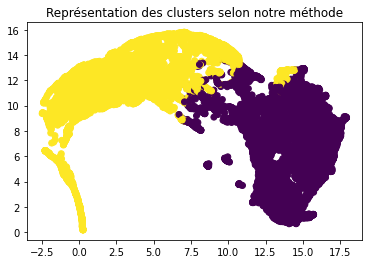

              precision    recall  f1-score   support

           0       0.74      0.49      0.59     11682
           1       0.18      0.40      0.25      3318

    accuracy                           0.47     15000
   macro avg       0.46      0.44      0.42     15000
weighted avg       0.62      0.47      0.51     15000

la mesure Normalized Mutual Information est  0.007442213375757553
laplacian


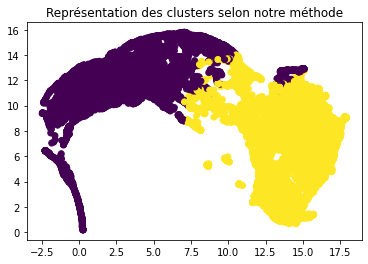

              precision    recall  f1-score   support

           0       0.82      0.51      0.63     11682
           1       0.26      0.61      0.36      3318

    accuracy                           0.53     15000
   macro avg       0.54      0.56      0.49     15000
weighted avg       0.70      0.53      0.57     15000

la mesure Normalized Mutual Information est  0.007337186285760284
linear


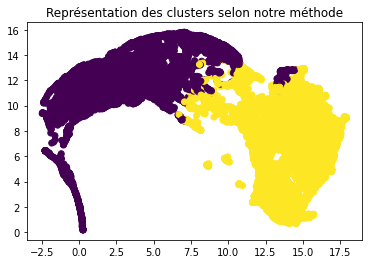

              precision    recall  f1-score   support

           0       0.82      0.51      0.63     11682
           1       0.26      0.60      0.36      3318

    accuracy                           0.53     15000
   macro avg       0.54      0.56      0.50     15000
weighted avg       0.70      0.53      0.57     15000

la mesure Normalized Mutual Information est  0.007508592537954545


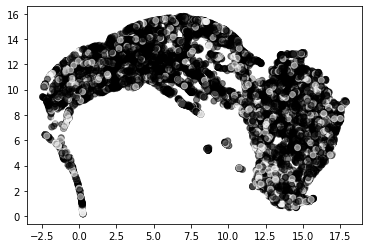

In [47]:
spec_clust(affinity='rbf')
spec_clust(affinity='polynomial')
spec_clust(affinity='laplacian')
spec_clust(affinity='linear')

plt.scatter(embed[:,0], embed[:,1], c=Y_Train.to_numpy(),alpha=0.5)

### 2.6 Consensus Clustering

In [48]:
def multiple_clustering(X=X_Train,n_clusters=2,visu=False):
  print('Mehtode CAH avec different linkage : ')
  a=CAH(array=X,linkage='ward',n_clusters=n_clusters,true_pred=Y_Train)
  b=CAH(array=X,linkage='complete',n_clusters=n_clusters,true_pred=Y_Train)
  c1 = np.concatenate((a,b), axis=0)
  print(len(c1))
  c=CAH(array=X,linkage='single',n_clusters=n_clusters,true_pred=Y_Train)
  c2 = np.concatenate((c1,c), axis=0)
  print(len(c2))
  d=CAH(array=X,linkage='average',n_clusters=n_clusters,true_pred=Y_Train)
  c3 = np.concatenate((c2,d), axis=0)
  print(len(c3))
  e=CAH(array=X,linkage='complete',affinity='manhattan',true_pred=Y_Train)
  c4 = np.concatenate((c3,e), axis=0)
  print(len(c4))
  print('Mehtode kmeans avec different initialisation : ')
  f=kmeans(array=X,init='random',n_clusters=n_clusters,true_pred=Y_Train)
  c5 = np.concatenate((c4,f), axis=0)
  print(len(c5))
  g=kmeans(array=X,init='k-means++',n_clusters=n_clusters,true_pred=Y_Train)
  c6 = np.concatenate((c5,g), axis=0)
  return c6

In [49]:
part= multiple_clustering()
part = part.reshape((7, len(X_Train)))
np.max(part)

Mehtode CAH avec different linkage : 
ward
euclidean
complete
euclidean
30000
single
euclidean
45000
average
euclidean
60000
complete
manhattan
75000
Mehtode kmeans avec different initialisation : 
90000


1

In [50]:
def condorcet(partition = part, array=X_Train,n_clusters=2,nb_methodes = 7):

    a=part[0]
    b=part[1]
    c=part[2]
    d=part[3]
    e=part[4]
    f=part[5]
    g=part[6]
  

    a[a == 0] = 2
    b[b == 0] = 2
    c[c == 0] = 2
    d[d == 0] = 2
    e[e == 0] = 2
    f[f == 0] = 2
    g[g == 0] = 2

    a = a.reshape((1, len(array)))
    b = b.reshape((1, len(array)))
    c = c.reshape((1, len(array)))
    d = d.reshape((1, len(array)))
    e = e.reshape((1, len(array)))
    f = f.reshape((1, len(array)))
    g = g.reshape((1, len(array)))

    mat_a = np.matmul(a.T, a)
    mat_b = np.matmul(b.T, b)
    mat_c = np.matmul(c.T, c)
    mat_d = np.matmul(d.T, d)
    mat_e = np.matmul(e.T, e)
    mat_f = np.matmul(f.T, f)
    mat_g = np.matmul(g.T, g)

    mat_a[mat_a == 4] = 1
    mat_b[mat_b == 4] = 1
    mat_c[mat_c == 4] = 1
    mat_d[mat_d == 4] = 1
    mat_e[mat_e == 4] = 1
    mat_f[mat_f == 4] = 1
    mat_g[mat_g == 4] = 1

    mat_a[mat_a == 2] = 0
    mat_b[mat_b == 2] = 0
    mat_c[mat_c == 2] = 0
    mat_d[mat_d == 2] = 0
    mat_e[mat_e == 2] = 0
    mat_f[mat_f == 2] = 0
    mat_g[mat_g == 2] = 0
    return(mat_a+mat_b+mat_c+mat_d+mat_e+mat_f+mat_g)

In [51]:
mat = condorcet()

rbf


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_spectral.py:590: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  "The spectral clustering API has changed. ``fit``"


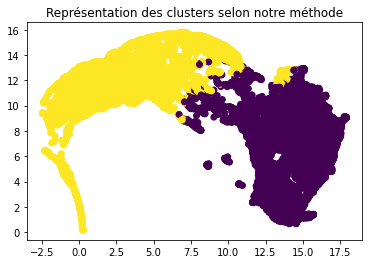

              precision    recall  f1-score   support

           0       0.74      0.48      0.58     11682
           1       0.18      0.40      0.25      3318

    accuracy                           0.46     15000
   macro avg       0.46      0.44      0.42     15000
weighted avg       0.62      0.46      0.51     15000

la mesure Normalized Mutual Information est  0.007839621324640587


In [52]:
def consensus_clustering(array=X_Train,mat_condorcet=mat,n_clusters=2,affinity='precomputed',embed=embed,true_pred=Y_Train):
    print(affinity)
    sc = SpectralClustering(n_clusters=2,affinity='precomputed').fit(array)
    labels = sc.labels_
    plt.scatter(embed[:,0], embed[:,1], c=labels)
    plt.show()
    print(labels)
    true_pred = true_pred.astype('int')
    print(confusion_matrix(true_pred.to_numpy(),labels))
    print(classification_report(true_pred.to_numpy(), labels, labels=[0,1]))
    print("la mesure Normalized Mutual Information est ",normalized_mutual_info_score(true_pred.to_numpy(),labels))

spec_clust(preprocessing.normalize(mat))
#‘discretize’, ‘cluster_qr’


## Partie 3 : Réechantillonage

In [53]:
smote_os = SMOTE(random_state = rs)
X_smote, y_smote = smote_os.fit_resample(X_Train, Y_Train)

random_os = RandomOverSampler(random_state = rs)
X_random, y_random = random_os.fit_resample(X_Train, Y_Train)

smote_border = BorderlineSMOTE(random_state = rs, kind = 'borderline-2')
X_smoteborder, y_smoteborder = smote_border.fit_resample(X_Train, Y_Train)

smote_svm = SVMSMOTE(random_state = rs)
X_smotesvm, y_smotesvm = smote_svm.fit_resample(X_Train, Y_Train)

sets = [(X_Train, Y_Train), (X_random, y_random), (X_smote, y_smote), (X_smoteborder, y_smoteborder), (X_smotesvm, y_smotesvm)]

clf = RandomForestClassifier(n_estimators=500,max_depth=10, random_state=rs)

for i in range(0, len(sets)):
    clf.fit(sets[i][0], sets[i][1])
    print(classification_report(Y_Test, clf.predict(X_Test)))

clf.fit(X_smote, y_smote)  
pred=clf.predict(X_Test) 

print(confusion_matrix(Y_Test.to_numpy(),pred))
print(classification_report(Y_Test.to_numpy(), pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     11682
           1       0.63      0.39      0.48      3318

    accuracy                           0.82     15000
   macro avg       0.74      0.66      0.68     15000
weighted avg       0.80      0.82      0.80     15000

              precision    recall  f1-score   support

           0       0.87      0.84      0.86     11682
           1       0.51      0.57      0.54      3318

    accuracy                           0.78     15000
   macro avg       0.69      0.71      0.70     15000
weighted avg       0.79      0.78      0.79     15000

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     11682
           1       0.51      0.56      0.53      3318

    accuracy                           0.78     15000
   macro avg       0.69      0.70      0.69     15000
weighted avg       0.79      0.78      0.79     15000

              preci

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


              precision    recall  f1-score   support

           0       0.87      0.85      0.86     11682
           1       0.51      0.56      0.53      3318

   micro avg       0.78      0.78      0.78     15000
   macro avg       0.69      0.70      0.69     15000
weighted avg       0.79      0.78      0.79     15000



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [54]:
clf = BalancedRandomForestClassifier(n_estimators=500,max_depth=10, random_state=rs)
clf.fit(X_Train, Y_Train)  
pred=clf.predict(X_Test) 

print(confusion_matrix(Y_Test.to_numpy(),pred))
print(classification_report(Y_Test.to_numpy(), pred, labels=[0,1]))

[[9263 2419]
 [1240 2078]]


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


              precision    recall  f1-score   support

           0       0.88      0.79      0.84     11682
           1       0.46      0.63      0.53      3318

   micro avg       0.76      0.76      0.76     15000
   macro avg       0.67      0.71      0.68     15000
weighted avg       0.79      0.76      0.77     15000



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
